# Text classification and sentiment analysis: Twitter

Once text data has been converted into numerical features using the natural language processing techniques discussed in the previous sections, text classification works just like any other classification task.

In this notebook, we will apply these preprocessing technique to news articles, product reviews, and Twitter data and teach various classifiers to predict discrete news categories, review scores, and sentiment polarity.

## Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
%matplotlib inline

from pathlib import Path
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# spacy, textblob and nltk for language processing
from textblob import TextBlob

# sklearn for feature extraction & modeling
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score


In [9]:
sns.set_style('white')


## Twitter Sentiment

### Download the data

We use a dataset that contains 1.6 million training and 350 test tweets from 2009 with algorithmically assigned binary positive and negative sentiment scores that are fairly evenly split.

Follow the [instructions](../data/twitter_sentiment.ipynb) to create the dataset.

- 0 - the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive); training data has no neutral tweets
- 1 - the id of the tweet (2087)
- 2 - the date of the tweet (Sat May 16 23:58:44 UTC 2009)
- 3 - the query (lyx). If there is no query, then this value is NO_QUERY. (only test data uses query)
- 4 - the user that tweeted (robotickilldozr)
- 5 - the text of the tweet (Lyx is cool)

### Read and preprocess train/test data

In [16]:
data_path = Path('.', 'data', 'sentiment140')
if not data_path.exists():
    data_path.mkdir(parents=True)

In [17]:
names = ['polarity', 'id', 'date', 'query', 'user', 'text']

Take a few preprocessing steps:
- remove tweets above the legal (at the time) length of 140 characters,
- binarize polarity, and 
- move the data to the faster parquet format.

In [22]:
def load_train_data():
    parquet_file = data_path / 'train.parquet'
    
    if not parquet_file.exists():
        df = (pd.read_csv(data_path / 'train.csv',
                          low_memory=False,
                          encoding='latin1',
                          header=None,
                          names=names,
                          parse_dates=['date'])
              .drop(['id', 'query'], axis=1)
              .drop_duplicates(subset=['polarity', 'text']))
        df = df[df.text.str.len() <= 140]
        df.polarity = (df.polarity > 0).astype(int)
        
        # fastparquet 엔진 사용
        df.to_parquet(parquet_file, engine='fastparquet')
        return df
    else:
        # 읽을 때도 fastparquet 엔진 지정
        return pd.read_parquet(parquet_file, engine='fastparquet')


In [24]:
train = load_train_data()
train.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 1566668 entries, 0 to 1599999
Data columns (total 4 columns):
 #   Column    Non-Null Count    Dtype         
---  ------    --------------    -----         
 0   polarity  1566668 non-null  int64         
 1   date      1566668 non-null  datetime64[ns]
 2   user      1566668 non-null  object        
 3   text      1566668 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 59.8+ MB


In [25]:
def load_test_data():
    parquet_file = data_path / 'test.parquet'
    
    if not parquet_file.exists():
        df = (pd.read_csv(data_path / 'test.csv',  # data_path 기준 통일
                          low_memory=False,
                          encoding='latin1',
                          header=None,
                          names=names,
                          parse_dates=['date'])
              .drop(['id', 'query'], axis=1)
              .drop_duplicates(subset=['polarity', 'text']))
        
        # 텍스트 길이 <= 140 & polarity 0 또는 4
        df = df[(df.text.str.len() <= 140) & (df.polarity.isin([0, 4]))]
        
        # fastparquet 엔진으로 저장
        df.to_parquet(parquet_file, engine='fastparquet')
        return df
    else:
        # 읽을 때도 fastparquet 지정
        return pd.read_parquet(parquet_file, engine='fastparquet')


In [26]:
test = load_test_data()
test.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 354 entries, 0 to 497
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   polarity  354 non-null    int64 
 1   date      354 non-null    object
 2   user      354 non-null    object
 3   text      354 non-null    object
dtypes: int64(1), object(3)
memory usage: 13.8+ KB


### Explore data

In [27]:
train.head()

,polarity,date,user,text
index,,,,
0,0,2009-04-06 22:19:45,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,2009-04-06 22:19:49,scotthamilton,is upset that he can't update his Facebook by ...
2,0,2009-04-06 22:19:53,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,2009-04-06 22:19:57,ElleCTF,my whole body feels itchy and like its on fire
4,0,2009-04-06 22:19:57,Karoli,"@nationwideclass no, it's not behaving at all...."


In [28]:
train.polarity = (train.polarity>0).astype(int)
train.polarity.value_counts()

polarity
1    784335
0    782333
Name: count, dtype: int64

In [29]:
test.polarity = (test.polarity>0).astype(int)
test.polarity.value_counts()

polarity
1    180
0    174
Name: count, dtype: int64

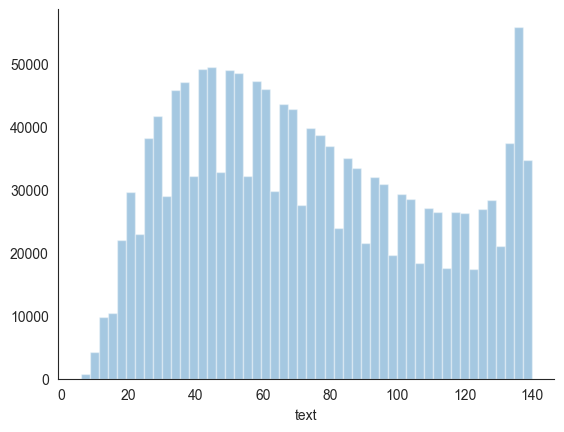

In [30]:
sns.distplot(train.text.str.len(), kde=False)
sns.despine();

In [31]:
train.date.describe()

count                          1566668
mean     2009-05-31 06:33:59.675214848
min                2009-04-06 22:19:45
25%                2009-05-28 22:48:57
50%         2009-06-02 02:49:41.500000
75%      2009-06-15 05:07:12.249999872
max                2009-06-25 10:28:31
Name: date, dtype: object

In [32]:
train.user.nunique()

650606

In [33]:
train.user.value_counts().head(10)

user
lost_dog           549
webwoke            341
SallytheShizzle    276
VioletsCRUK        275
mcraddictal        274
tsarnick           247
what_bugs_u        246
Karen230683        237
DarkPiano          232
SongoftheOss       226
Name: count, dtype: int64

### Create text vectorizer

We create a document-term matrix with 934 tokens as follows:

In [34]:
vectorizer = CountVectorizer(min_df=.001, max_df=.8, stop_words='english')
train_dtm = vectorizer.fit_transform(train.text)

In [35]:
train_dtm

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 6332930 stored elements and shape (1566668, 934)>

In [36]:
test_dtm = vectorizer.transform(test.text)

### Train Naive Bayes Classifier

In [37]:
nb = MultinomialNB()
nb.fit(train_dtm, train.polarity)

,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


### Predict Test Polarity

In [38]:
predicted_polarity = nb.predict(test_dtm)

### Evaluate Results

In [39]:
accuracy_score(test.polarity, predicted_polarity)

0.7768361581920904

### TextBlob for Sentiment Analysis

In [40]:
sample_positive = train.text.loc[256332]
print(sample_positive)
parsed_positive = TextBlob(sample_positive)
parsed_positive.polarity

Ok its cake and ice cream time! Ha! See what I'm talking about! The temptation is there! 


1.0

In [41]:
sample_negative = train.text.loc[636079]
print(sample_negative)
parsed_negative = TextBlob(sample_negative)
parsed_negative.polarity

 i hate this place


-0.8

In [42]:
def estimate_polarity(text):
    return TextBlob(text).sentiment.polarity

In [43]:
train[['text']].sample(10).assign(sentiment=lambda x: x.text.apply(estimate_polarity)).sort_values('sentiment')

,text,sentiment
index,,
23757,It is 7 am on my day off and I am awake! Serio...,-0.145833
88633,Im a hungover bunny 2day,0.000000
1416799,Did I make a Natalia Rivera in Sims 3? Yes. Ye...,0.000000
1282044,"@AIEF Well, I'd thought I'd refresh a bit. And...",0.000000
1524617,toodle pip for now,0.000000
120020,My bed is screaming for me..I'm that loved..GR...,0.000000
1522217,"@BearTwinsMom regardless, welcome back!",0.400000
972694,Best view yesterday..balancing on a planter le...,0.650000
1384258,And I'm making my very own homemade album! Jus...,1.000000


### Compare with TextBlob Polarity Score

We also obtain TextBlob sentiment scores for the tweets and note (see left panel in below figure) that positive test tweets receive a significantly higher sentiment estimate. We then use the MultinomialNB ‘s model .predict_proba() method to compute predicted probabilities and compare both models using the respective Area Under the Curve (see right panel below).

In [44]:
test['sentiment'] = test.text.apply(estimate_polarity)

In [45]:
accuracy_score(test.polarity, (test.sentiment>0).astype(int))

0.7429378531073446

#### ROC AUC Scores

In [46]:
roc_auc_score(y_true=test.polarity, y_score=test.sentiment)

0.8254948914431672

In [47]:
roc_auc_score(y_true=test.polarity, y_score=nb.predict_proba(test_dtm)[:, 1])

0.848595146871009

In [48]:
fpr_tb, tpr_tb, _ = roc_curve(y_true=test.polarity, y_score=test.sentiment)
roc_tb = pd.Series(tpr_tb, index=fpr_tb)
fpr_nb, tpr_nb, _ = roc_curve(y_true=test.polarity, y_score=nb.predict_proba(test_dtm)[:, 1])
roc_nb = pd.Series(tpr_nb, index=fpr_nb)

The Naive Bayes model outperforms TextBlob in this case.

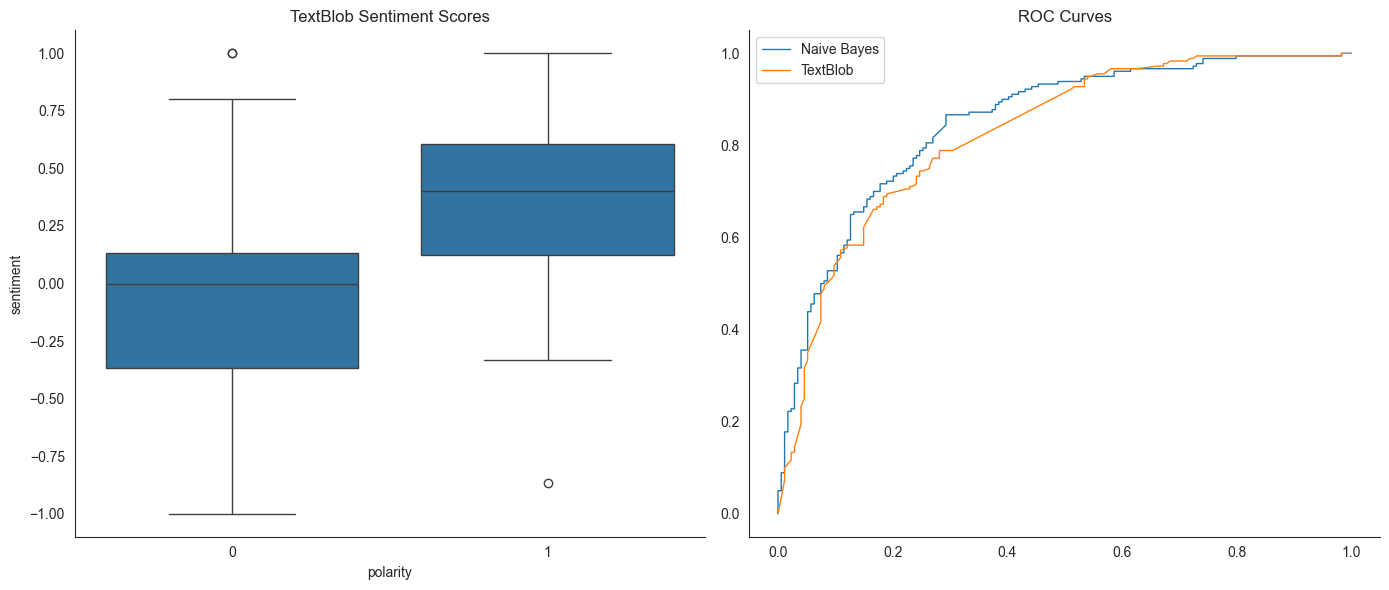

In [49]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 6))
sns.boxplot(x='polarity', y='sentiment', data=test, ax=axes[0])
axes[0].set_title('TextBlob Sentiment Scores')
roc_nb.plot(ax=axes[1], label='Naive Bayes', legend=True, lw=1, title='ROC Curves')
roc_tb.plot(ax=axes[1], label='TextBlob', legend=True, lw=1)
sns.despine()
fig.tight_layout();